In [2]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

### A/B тестирование

В этом задании вы познакомитесь с A/B тестированием и примените полученные знания по статистике. 

Рассмотрим A/B тестирование на примере сайта. У сайта есть два дизайна - старый и новый, и мы хотим оценить, насколько новый дизайн лучше старого. Для этого пользователи сайта случайным образом разделяются на контрольную и тестовую группы. Контрольной группе показывается старая версия сайта, тестовой группе - измененная версия. Оценить изменение можно несколькими способами, самый простой - оценить конверсию. Конверсия - доля пользователей, совершивших заранее определенное действие(например подписка, нажатие на кнопку, заполнение формы).

### Описание данных

Для начала нужно загрузить данные из файла `a_b_testing.csv` при помощи функции `read_csv` из библиотеки `pandas`. В данном случае 1 - была совершена подписка на сайт, 0 - подписки не было. A - контрольная группа, B - тестовая группа.

Далее нужно выполнить следующие пункты, описание выходного формата содержится внутри каждого задания.

### Доверительный интервал

В видео про доверительный интервал мы рассмотрели, как можно аппроксимировать биномиальное распределение нормальным. В некоторых случаях параметры нормального распределения можно вывести математически и ниже мы рассмотрим как.

Представим количество пользователей как случайную величину из биномиального распределения с параметрами  `n`  - количество пользователей и `p` - вероятность конверсии или как сумму  `n`  независимых бросаний монетки. Определим следующую случайную величину:

$$Y = X_{1} + X_{2} + \dots + X_{n} , \, $$
где случайная величина $X_{i}$ имеет распределение Бернулли. Для случайной величины $Y$ математическое ожидание и дисперсия равны:

$$\mu = np, \, \sigma^{2} = np\cdot(1 - p)$$

Далее применяя центральную предельную теорему(случайные величины $X_{i}$ распределены независимо и размер выборки большой), получаем что 

$$Y \sim \mathcal{N}(np \, np\cdot(1 - p))\$$

Мы перешли от биномиального распределения к нормальному. Следующий шаг - стандартизация нормального распределения:

$$Z = \frac{Y - np}{\sqrt{np\cdot(1-p)}} \sim \mathcal{N}(0, \, 1) $$ 

Преобразуем выражение выше:

$$Z = \frac{Y - np}{\sqrt{np\cdot(1-p)}} = \frac{\frac{Y}{n} - p}{\sqrt{\frac{p(1-p)}{n}}} \sim \mathcal{N}(0, \, 1) $$

Так как среднее значение по выборке - это наблюдаемый процент конверсии, то доверительный интервал будет выглядеть следующим образом:

$${P}\left(p - z_{1-\frac{\alpha}{2}} \sqrt{\frac{p(1-p)}{n}} \le \mu \le p + z_{1-\frac{\alpha}{2}}\sqrt{\frac{p(1-p)}{n}}\right) = 1-\alpha$$

### ЗАДАНИЕ

Найдите доверительный интервал для средней конверсии пользователей из контрольной выборки с уровнем значимости 95%. Округлите левую и правую границу с точностью до двух знаков после запятой. Запишите значения левой и правой границ через запятую, сохраняя приведенный порядок, в переменную `answer1`, которая будет являтся строкой.

#### РЕШЕНИЕ

In [3]:
df = pd.read_csv('a_b_testing.csv')
df.groupby('group').get_group('A')['converted']

0       1
1       0
2       0
4       1
7       0
       ..
3993    1
3994    0
3995    1
3996    0
3999    1
Name: converted, Length: 2037, dtype: int64

In [4]:
sample_size = 500
convA= df.groupby('group').get_group('A')['converted']
convB= df.groupby('group').get_group('B')['converted']
sample = np.random.choice(a = convA, size = sample_size)
sample_mean = sample.mean()
st_dev = convA.std()
print(sample_mean, st_dev)

0.4 0.49229450489963195


In [30]:
def compute_ci_t(sample, alpha=0.95):
    n = sample.shape[0]
    mu, se = np.mean(sample), stats.sem(sample)
    bound = se * stats.t.ppf((1+alpha)/2., n-1)
    return mu - bound, mu + bound

In [31]:
ci_t = compute_ci_t(sample, alpha=0.95)
print(ci_t)

(0.3628074635512486, 0.44919253644875146)


In [42]:
def generate_sample(data, sample_size, numb_sample):
    sample_mean = []
    for i in range(numb_sample):
        sample = np.random.choice(a=data, size=sample_size)
        sample_mean.append(np.mean(sample))
    
    return sample_mean
    
sample_size = 1000
numb_sample = 30000

sample_means = generate_sample(convB, sample_size, numb_sample)


(array([1.60000e+01, 4.20000e+02, 5.25800e+03, 2.97050e+04, 8.01280e+04,
        1.02433e+05, 6.16650e+04, 1.77680e+04, 2.43700e+03, 1.70000e+02]),
 array([0.362 , 0.3761, 0.3902, 0.4043, 0.4184, 0.4325, 0.4466, 0.4607,
        0.4748, 0.4889, 0.503 ]),
 <BarContainer object of 10 artists>)

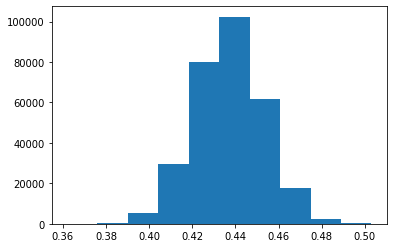

In [41]:
plt.hist(sample_means)

In [44]:
np.sort(sample_means)
lb = np.percentile(sample_means, 5)
ub = np.percentile(sample_means, 95)
print("conf interval for bootstrap:", (lb, ub))

conf interval for bootstrap: (0.411, 0.463)


### Задача A/B тестирования

Рассмотрим независимые выборки $X$ и $Y$ для которых есть $\mu_x$ и $\mu_y$, определяющие среднее значение распределения.

Рассматривается следующая гипотеза:
$$
H_0: \mu_x = \mu_y
$$
против альтернативы:

$$
H_1: \mu_x \ne \mu_y.
$$

Если гипотеза $H_0$ отвергается, то показатель действительно поменялся.

Также можно тест можно записать и другим способом:
$$
H_0: \mu_x \le \mu_y
$$

против альтернативы:

$$
H_1: \mu_x > \mu_y
$$

### Задание по статистике Стьюдента 

Найдите значение статистики Стьюдента в предположении независимости выборок по формуле:

$$
T(X, Y) = \frac{\bar{X} - \bar{Y}}{\sqrt{\frac{s_x^2}{n} + \frac{s_y^2}{m}}}
$$

где `n` - размер контрольной выборки, `m`  - размер тестовой выборки.

Ответ запишите в переменную `answer2` с точностью до двух знаков после запятой.

### РЕШЕНИЕ

### Статистика Стьюдента из библиотеки Scipy

Найдите p-value для статистики Стьюдента, используя функцию `stats.ttest_ind`.

### РЕШЕНИЕ

In [8]:
from scipy.stats import ttest_ind

ttest_ind(convA.sample(500),
        convB.sample(500))

Ttest_indResult(statistic=-0.82913008213787, pvalue=0.4072290613898625)

Дополнительная проверка: значение статистики Стьюдента, посчитанная двумя способами, должны совпадать.

Ответ запишите в переменную `answer3` с точностью до 2 знака после запятой